In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
import json
import re

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(plt.__version__)
print(json.__version__)
print(re.__version__)

# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
1.21.4
1.3.3
3.4.3
2.0.9
2.2.1
2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


### Tokenizer 준비

In [2]:
import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = os.getenv('HOME')+'/aiffel/bert_pretrain/models/ko_8000'
vocab_size = 8000
#spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [4]:
# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [5]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

In [6]:
vocab_list[:10]

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']

### MASK 생성

\_로 시작하는 단어는 단어의 시작

전체 단어 중 15%를 마스킹,

마스킹 별로 80%는 [MASK], 10%는 랜덤한 토큰, 나머지 10%는 원래 토큰을 그대로 사용하였습니다.

In [7]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
    return tokens, mask_idx, mask_label

In [8]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [9]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0

    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)


            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)


            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

    return instances

In [10]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)    
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [11]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

#make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

In [12]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

1630496

In [13]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [14]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=None)

  0%|          | 0/1630496 [00:00<?, ?it/s]

/tmp/ipykernel_96/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_96/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

5번token([CLS])으로 시작해서 4번 token([SEP])으로 끝나는 데이터들

In [15]:
print(pre_train_inputs[0])

[[   5   10 1605 ...   16 3599    4]
 [   5    6    6 ... 4313 4290    4]
 [   5 3873 3667 ...   76  955    4]
 ...
 [   5 3662    6 ... 3650 3731    4]
 [   5  108 3663 ...    0    0    0]
 [   5   55 3674 ...    0    0    0]]


데이터 순서가 바뀌어있으면 0, 순서가 올바르면 1

In [16]:
print(pre_train_labels[0])

[0 1 1 ... 0 1 1]


### 유틸리티 함수

In [17]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

GELU

In [18]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [19]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [20]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [21]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

Position Embedding

In [22]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

ScaleDotProductAttention + MultiHeadAttention

In [23]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        # (bs, n_head, Q_len, d_head)
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # transpose and liner
        # (bs, Q_len, n_head, d_head)
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        # (bs, Q_len, d_model)
        attn_out = tf.reshape(attn_out, [batch_size, -1, self.d_model])
        # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out)

        return attn_out

transformer encoder

In [25]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

BERT

In [27]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

pretrain용 BERT 모델

In [28]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [29]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

### 4M model

lms 노드에 있는 기본 프리셋으로 진행했을 때, 4M의 모델이 만들어졌습니다.

학습시간은 총 약 10시간 정도 걸렸습니다.

In [82]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [83]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 3s 10ms/step - loss: 9.6809 - nsp_loss: 0.6697 - mlm_loss: 9.0112 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 10ms/step - loss: 8.4637 - nsp_loss: 0.5138 - mlm_loss: 7.9499 - nsp_acc: 0.9000 - mlm_acc: 0.0000e+00


### pretrain 진행

In [84]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [85]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [86]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

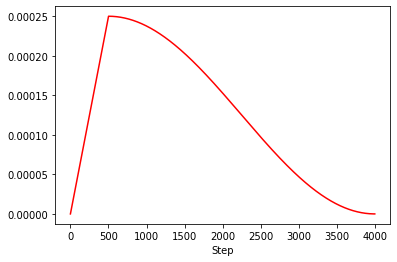

In [87]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [88]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                

### 모델 학습

In [35]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 254770


In [38]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=save_weights)
# 모델 인자에는 inputs, labels, epochs, batch size, callback 이 필요해요.

Epoch 1/10
25477/25477 [==============================] - 3453s 135ms/step - loss: 15.4352 - nsp_loss: 0.3995 - mlm_loss: 15.0356 - nsp_acc: 0.9070 - mlm_lm_acc: 0.1656

Epoch 00001: mlm_lm_acc improved from -inf to 0.16556, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
25477/25477 [==============================] - 3456s 136ms/step - loss: 11.0104 - nsp_loss: 0.3403 - mlm_loss: 10.6701 - nsp_acc: 0.9721 - mlm_lm_acc: 0.2901

Epoch 00002: mlm_lm_acc improved from 0.16556 to 0.29011, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
25477/25477 [==============================] - 3456s 136ms/step - loss: 10.3176 - nsp_loss: 0.3324 - mlm_loss: 9.9852 - nsp_acc: 0.9803 - mlm_lm_acc: 0.3203

Epoch 00003: mlm_lm_acc improved from 0.29011 to 0.32031, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
25477/25477 [==============================] - 3454s 136ms/step - loss: 10.0016 - nsp_loss: 0

nsp의 경우 거의 1.0의 acc을 가지고,
mlm의 경우 acc은 약 0.4, loss는 약 9정도로 수렴하는 모습을 보였습니다.

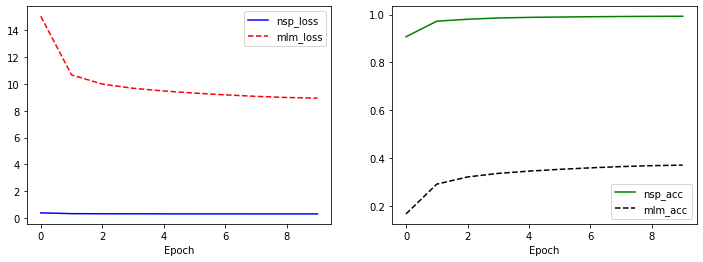

In [39]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### 1M 모델

d_model, n_head, d_head, d_ff, n_layer의 값을 전체적으로 줄여 1M 모델을 만들어

학습을 진행했습니다.

In [122]:
config = Config({"d_model": 96, "n_head": 2, "d_head": 48, "dropout": 0.1, "d_ff": 256, "layernorm_epsilon": 0.001, "n_layer": 2, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 96,
 'n_head': 2,
 'd_head': 48,
 'dropout': 0.1,
 'd_ff': 256,
 'layernorm_epsilon': 0.001,
 'n_layer': 2,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [123]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 96), (None,  967904      enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            9504        bert[0][0]                

모델 학습

In [124]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 254770


In [125]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train_1M.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=save_weights)
# 모델 인자에는 inputs, labels, epochs, batch size, callback 이 필요해요.

Epoch 1/10
25477/25477 [==============================] - 1505s 59ms/step - loss: 17.8101 - nsp_loss: 0.4506 - mlm_loss: 17.3594 - nsp_acc: 0.8473 - mlm_lm_acc: 0.0962

Epoch 00001: mlm_lm_acc improved from -inf to 0.09616, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train_1M.hdf5
Epoch 2/10
25477/25477 [==============================] - 1505s 59ms/step - loss: 13.6342 - nsp_loss: 0.3687 - mlm_loss: 13.2656 - nsp_acc: 0.9425 - mlm_lm_acc: 0.1906

Epoch 00002: mlm_lm_acc improved from 0.09616 to 0.19060, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train_1M.hdf5
Epoch 3/10
25477/25477 [==============================] - 1504s 59ms/step - loss: 12.5333 - nsp_loss: 0.3557 - mlm_loss: 12.1776 - nsp_acc: 0.9560 - mlm_lm_acc: 0.2259

Epoch 00003: mlm_lm_acc improved from 0.19060 to 0.22591, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train_1M.hdf5
Epoch 4/10
25477/25477 [==============================] - 1502s 59ms/step - loss: 12.2549 - nsp_l

4M 모델보다 mlm loss의 값이 약 3정도 높은 곳에서 수렴하고, acc도 0.1 차이가 발생했습니다.

nsp는 둘다 높은 acc을 가졌습니다.

![](images/output1.png)
![](images/output2.png)

### 4M 모델 불러오기

In [89]:
pre_train_model.load_weights(f"{model_dir}/bert_pre_train.hdf5")

In [90]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
test_text = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

enc_token = [vocab.piece_to_id(p) for p in test_text]
segment = []
seg_id = 0
for token in test_text:
    segment.append(seg_id)
    if token == "[SEP]":
        seg_id = 1  # 첫 [SEP] 이후부터는 segment 1로 전환

input_ids = np.array([enc_token], dtype=np.int32)
segment_ids = np.array([segment], dtype=np.int32)

print("Token IDs:", input_ids)
print("Segment IDs:", segment_ids)

pre_train_model.predict((input_ids, segment_ids))

Token IDs: [[   5  199 3657 3853 3657   77 3608  114  368  687  500 3633   13 3968
  3613 3596 7213 3610  516 4265 3597  201 3630  404  254 3600  391 4192
    25  938 3982 3821   64 4192   25   64 3981 2848  764 3672 3602 2288
    25 4357 3622  456 3741 3683   80 4809 3600    4  516 3747 4354   45
  4014   24 5531 3601 1130 2574 3211 3727 3315 4221 3612  266 3600   60
  3646   34 4220 3607  239 4289  851  290  119   25   93 1316 3815 3738
   368 2715  736 3600   13 3784 3815 1144 3609 2645 3598 3781    4]]
Segment IDs: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


(array([[0.26894322, 0.73105675]], dtype=float32),
 array([[[2.40792608e-10, 5.85199305e-05, 2.46435150e-10, ...,
          3.28789298e-07, 1.31485436e-07, 6.63250432e-07],
         [1.73084227e-15, 3.03982745e-07, 1.75043657e-15, ...,
          6.36599884e-10, 1.18749316e-10, 7.19960203e-10],
         [2.13036172e-14, 1.94850045e-07, 2.16941469e-14, ...,
          1.12385867e-09, 8.97136254e-11, 7.04412795e-09],
         ...,
         [5.03130900e-16, 1.05240258e-06, 5.11772013e-16, ...,
          3.06713786e-11, 1.70651479e-10, 2.94157511e-11],
         [2.84203433e-13, 1.11571666e-07, 2.89997410e-13, ...,
          5.11052800e-09, 6.06360295e-09, 2.86458213e-09],
         [1.03151009e-10, 1.25211245e-05, 1.05275594e-10, ...,
          1.89520776e-07, 1.89051079e-07, 7.49751507e-07]]], dtype=float32))

In [91]:
def mask_segment_b_and_predict(enc_token, segment, model, vocab):
    import numpy as np

    # 1. 준비
    input_ids = np.array([enc_token], dtype=np.int32)      # (1, seq_len)
    segment_ids = np.array([segment], dtype=np.int32)      # (1, seq_len)

    # 2. 마스킹
    mask_token_id = vocab.piece_to_id("[MASK]")
    masked_input_ids = input_ids.copy()
    masked_input_ids[0][segment_ids[0] == 1] = mask_token_id  # B 영역만 마스킹

    # 3. 예측
    nsp_pred, mlm_pred = model.predict((masked_input_ids, segment_ids))

    # 4. 복원
    recovered_ids = masked_input_ids.copy()
    for i in range(segment_ids.shape[1]):
        if segment_ids[0][i] == 1:  # segment B
            recovered_ids[0][i] = np.argmax(mlm_pred[0][i])

    # 5. 토큰 디코딩
    recovered_tokens = [vocab.id_to_piece(int(tok)) for tok in recovered_ids[0]]

    return recovered_tokens

B 문장을 전부 마스킹했을 때 결과 분석

훈련 때 mask가 전부 가려진 것을 훈련해본 적이 없어서 낮은 성능을 보이는 것으로 분석된다.

In [93]:
recovered_tokens = mask_segment_b_and_predict(enc_token, segment, pre_train_model, vocab)
print("복원된 문장:", "".join(recovered_tokens).replace("▁", " ").strip())

복원된 문장: [CLS] 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP] 노가리리리리)))))))))))))))(((((-----------------((


In [94]:
def mask_segment_b_word_level_from_tokenized(test_text, model, vocab, mask_prob=0.15, mask_ab='all'):
    import numpy as np
    import random

    input_ids = [vocab.piece_to_id(t) for t in test_text]
    sep_index_1 = test_text.index("[SEP]")
    sep_index_2 = len(test_text) - 1  # 마지막 [SEP]

    segment_ids = [0] * (sep_index_1 + 1) + [1] * (len(test_text) - sep_index_1 - 1)

    # 단어 단위 후보군 (A, B, all 구분)
    cand_idx = []
    if mask_ab is not None:
        for i, token in enumerate(test_text):
            if token in ["[CLS]", "[SEP]"]:
                continue
            if (mask_ab == 'a' and segment_ids[i] != 0) or \
               (mask_ab == 'b' and segment_ids[i] != 1):
                continue
            if cand_idx and not token.startswith("▁"):
                cand_idx[-1].append(i)
            else:
                cand_idx.append([i])

    # 마스킹 적용
    masked_input_ids = input_ids.copy()
    if cand_idx:
        num_to_mask = max(1, int(len(cand_idx) * mask_prob))
        masked_indices = random.sample(cand_idx, num_to_mask)
        mask_token_id = vocab.piece_to_id("[MASK]")
        for index_group in masked_indices:
            for idx in index_group:
                masked_input_ids[idx] = mask_token_id

    # 예측
    input_ids_np = np.array([masked_input_ids], dtype=np.int32)
    segment_ids_np = np.array([segment_ids], dtype=np.int32)
    nsp_pred, mlm_pred = model.predict((input_ids_np, segment_ids_np))

    # NSP 확률 추출 (두 문장이 연결될 확률)
    is_next_prob = float(nsp_pred[0][1])  # NSP: [not_next, is_next]

    # 복원
    recovered_ids = masked_input_ids.copy()
    if cand_idx:
        for index_group in masked_indices:
            for idx in index_group:
                recovered_ids[idx] = np.argmax(mlm_pred[0, idx])

    # 디코딩
    masked_pieces = [vocab.id_to_piece(int(i)) for i in masked_input_ids]
    recovered_pieces = [vocab.id_to_piece(int(i)) for i in recovered_ids]

    # A/B 분리
    masked_a = "".join(masked_pieces[0:sep_index_1+1]).replace("▁", " ").strip()
    masked_b = "".join(masked_pieces[sep_index_1+1:sep_index_2+1]).replace("▁", " ").strip()
    recovered_a = "".join(recovered_pieces[0:sep_index_1+1]).replace("▁", " ").strip()
    recovered_b = "".join(recovered_pieces[sep_index_1+1:sep_index_2+1]).replace("▁", " ").strip()

    return masked_a, masked_b, recovered_a, recovered_b, is_next_prob


In [96]:
masked_a, masked_b, recovered_a, recovered_b, is_next_prob = mask_segment_b_word_level_from_tokenized(
    test_text, pre_train_model, vocab, mask_prob=0.15, mask_ab='all'
)

print("원본 A 문장:\n", string_a)
print("원본 B 문장:\n", string_b)
print("\n 마스킹 A 문장:\n", masked_a)
print(" 마스킹 B 문장:\n", masked_b)
print("\n 복원된 A 문장:\n", recovered_a)
print("복원된 B 문장:\n", recovered_b)

print(f"\n NSP 확률 (두 문장이 이어질 확률): {is_next_prob:.4f}")

원본 A 문장:
 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에
원본 B 문장:
 손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던

 마스킹 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은[MASK][MASK][MASK] 손님이 많아 첫[MASK][MASK] 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
 마스킹 B 문장:
 손바닥[MASK][MASK] 기쁨의 눈물이 흘러 컬컬한 목에 모주[MASK][MASK][MASK][MASK][MASK] 몇 달 포 전부터 콜록거리는 아내 생각에 그토록[MASK][MASK] 싶다던[SEP]

 복원된 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은 그째. 손님이 많아 첫 날은 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
복원된 B 문장:
 손바닥 의 기쁨의 눈물이 흘러 컬컬한 목에 모주 을들다. 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 살고 싶다던[SEP]

 NSP 확률 (두 문장이 이어질 확률): 0.7310


결과 분석

mlm의 경우 단어 단위로는 생성이 잘 되지만, 문장 단위로는 어법저으로 어색한 부분이 발생하는 모습입니다.

nsp의 경우 0.7정도로 높은 편향을 가지지는 않지만, 예측의 방향성은 올바르게 보입니다.

In [109]:
string_a = "이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까"
string_b = "눈 비비며 빼꼼히 창밖을 내다보니 삼삼오오 아이들은 재잘대며 학교 가고 산책 갔다 오시는 아버지의 양손에는 효과를 알 수 없는 약수가 하나 가득"
string_c = "내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요"
test_text = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_c) + ["[SEP]"]

enc_token = [vocab.piece_to_id(p) for p in test_text]
segment = []
seg_id = 0
for token in test_text:
    segment.append(seg_id)
    if token == "[SEP]":
        seg_id = 1  # 첫 [SEP] 이후부터는 segment 1로 전환

input_ids = np.array([enc_token], dtype=np.int32)
segment_ids = np.array([segment], dtype=np.int32)

print("Token IDs:", input_ids)
print("Segment IDs:", segment_ids)

pre_train_model.predict((input_ids, segment_ids))

Token IDs: [[   5    8 3829   26 4036 1057  303 3649  138 4362 3688 3622  865 3788
  3696 3703  401 3648 3637   13 5378 4360   26 4356 3669  998 3607 3596
  6281 3598  388 3697  324 3596 5047 3921   21 4059 1130 3638 3623 3669
    77 4035 3696 3609   80 4102 3612 3182  329  174 4001 3614 3764 3804
   150 3804    4  114 1130 3772 3600 1599  848 1130 3772 3600   58  126
  3870  382 3684  868  141 4547 1995 3867   58 3602 3596 4044  481 2149
  3596 5609 3908 3628 1599 3602  687 2106 2149  207 3908 3628   13 2549
    58 3601 1911 3597 3364 3263 1911 3597   62 3667 1816  313 3600  435
   150 3630 3769    4]]
Segment IDs: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1]]


(array([[0.64812565, 0.35187435]], dtype=float32),
 array([[[7.60500551e-11, 1.18901640e-04, 7.71229816e-11, ...,
          2.43637345e-07, 8.37495861e-07, 6.65926734e-07],
         [1.81994600e-15, 5.53422197e-08, 1.85019312e-15, ...,
          1.00322251e-09, 3.86792959e-10, 3.49805768e-10],
         [2.10490669e-14, 3.02342733e-06, 2.13275527e-14, ...,
          2.34534642e-10, 2.50348464e-10, 1.21330140e-10],
         ...,
         [1.45606776e-14, 4.63521064e-06, 1.48587129e-14, ...,
          3.07598863e-10, 1.15875343e-09, 4.07584660e-10],
         [1.16434735e-13, 1.38996329e-05, 1.18075837e-13, ...,
          5.57978819e-09, 7.10783121e-09, 2.61102251e-09],
         [5.66682708e-11, 1.19636454e-04, 5.76326278e-11, ...,
          1.35769554e-07, 1.71141409e-07, 2.91211308e-07]]], dtype=float32))

In [110]:
recovered_tokens = mask_segment_b_and_predict(enc_token, segment, pre_train_model, vocab)
print("복원된 문장:", "".join(recovered_tokens).replace("▁", " ").strip())

복원된 문장: [CLS] 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까[SEP] 오리리리 ((()))))((((((-----------------((((((((((((((((((())


In [114]:
masked_a, masked_b, recovered_a, recovered_b, is_next_prob = mask_segment_b_word_level_from_tokenized(
    test_text, pre_train_model, vocab, mask_prob=0.1, mask_ab=None,
)

print("원본 A 문장:\n", string_a)
print("원본 B 문장:\n", string_c)
print("\n 마스킹 A 문장:\n", masked_a)
print(" 마스킹 B 문장:\n", masked_b)
print("\n 복원된 A 문장:\n", recovered_a)
print("복원된 B 문장:\n", recovered_b)

print(f"\n NSP 확률 (두 문장이 이어질 확률): {is_next_prob:.4f}")

원본 A 문장:
 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까
원본 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요

 마스킹 A 문장:
 [CLS] 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까[SEP]
 마스킹 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요[SEP]

 복원된 A 문장:
 [CLS] 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까[SEP]
복원된 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요[SEP]

 NSP 확률 (두 문장이 이어질 확률): 0.3519


서로 다른 도메인의 문장을 사용하여 nsp를 추론해본 경우

올바른 방향으로 잘못된 연결을 잘 찾아냈습니다.

In [121]:
masked_a, masked_b, recovered_a, recovered_b, is_next_prob = mask_segment_b_word_level_from_tokenized(
    test_text, pre_train_model, vocab, mask_prob=0.1, mask_ab='all',
)

print("원본 A 문장:\n", string_a)
print("원본 B 문장:\n", string_c)
print("\n 마스킹 A 문장:\n", masked_a)
print(" 마스킹 B 문장:\n", masked_b)
print("\n 복원된 A 문장:\n", recovered_a)
print("복원된 B 문장:\n", recovered_b)

print(f"\n NSP 확률 (두 문장이 이어질 확률): {is_next_prob:.4f}")

원본 A 문장:
 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까
원본 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요

 마스킹 A 문장:
 [CLS] 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게[MASK][MASK] 깬다[MASK][MASK] 하나 햇살 가득 눈부시게 비쳐오고[MASK][MASK][MASK] 냉기에[MASK][MASK][MASK][MASK][MASK] 말까[SEP]
 마스킹 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요[SEP]

 복원된 A 문장:
 [CLS] 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 나을 깬다 나까 하나 햇살 가득 눈부시게 비쳐오고 다. 냉기에 려다오지 말까[SEP]
복원된 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요[SEP]

 NSP 확률 (두 문장이 이어질 확률): 0.5129


마스킹을 적용한 경우, nsp 확률을 약 0.5로 분석하여 잘 구별하지 못하는 것을 확인할 수 있습니다.

### 1M 추론

In [127]:
pre_train_model.load_weights(f"{model_dir}/bert_pre_train_1M.hdf5")

In [128]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
test_text = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

enc_token = [vocab.piece_to_id(p) for p in test_text]
segment = []
seg_id = 0
for token in test_text:
    segment.append(seg_id)
    if token == "[SEP]":
        seg_id = 1  # 첫 [SEP] 이후부터는 segment 1로 전환

input_ids = np.array([enc_token], dtype=np.int32)
segment_ids = np.array([segment], dtype=np.int32)

print("Token IDs:", input_ids)
print("Segment IDs:", segment_ids)

pre_train_model.predict((input_ids, segment_ids))

Token IDs: [[   5  199 3657 3853 3657   77 3608  114  368  687  500 3633   13 3968
  3613 3596 7213 3610  516 4265 3597  201 3630  404  254 3600  391 4192
    25  938 3982 3821   64 4192   25   64 3981 2848  764 3672 3602 2288
    25 4357 3622  456 3741 3683   80 4809 3600    4  516 3747 4354   45
  4014   24 5531 3601 1130 2574 3211 3727 3315 4221 3612  266 3600   60
  3646   34 4220 3607  239 4289  851  290  119   25   93 1316 3815 3738
   368 2715  736 3600   13 3784 3815 1144 3609 2645 3598 3781    4]]
Segment IDs: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


(array([[0.69621384, 0.30378616]], dtype=float32),
 array([[[1.09724079e-13, 1.38291653e-04, 1.11115334e-13, ...,
          1.43784774e-07, 4.13300199e-07, 5.77842400e-07],
         [1.92372035e-16, 3.29452462e-07, 1.91089918e-16, ...,
          2.06745024e-10, 3.91467345e-11, 1.52085261e-10],
         [1.29273771e-16, 5.11932114e-07, 1.26595559e-16, ...,
          1.60170366e-09, 1.01234021e-09, 5.94907290e-10],
         ...,
         [7.69384195e-21, 6.95987069e-07, 7.39317068e-21, ...,
          1.36436855e-13, 3.55653712e-13, 7.62274765e-14],
         [3.05303735e-16, 2.44709372e-06, 2.97510952e-16, ...,
          1.55383623e-10, 1.28010741e-10, 7.03881953e-10],
         [1.76578294e-12, 4.76002526e-07, 1.75158369e-12, ...,
          1.07106697e-08, 6.51183196e-09, 1.80109776e-08]]], dtype=float32))

In [131]:
masked_a, masked_b, recovered_a, recovered_b, is_next_prob = mask_segment_b_word_level_from_tokenized(
    test_text, pre_train_model, vocab, mask_prob=0.1, mask_ab='all',
)

print("원본 A 문장:\n", string_a)
print("원본 B 문장:\n", string_b)
print("\n 마스킹 A 문장:\n", masked_a)
print(" 마스킹 B 문장:\n", masked_b)
print("\n 복원된 A 문장:\n", recovered_a)
print("복원된 B 문장:\n", recovered_b)

print(f"\n NSP 확률 (두 문장이 이어질 확률): {is_next_prob:.4f}")

원본 A 문장:
 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에
원본 B 문장:
 손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던

 마스킹 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
 마스킹 B 문장:
 [MASK][MASK][MASK][MASK][MASK] 기쁨의[MASK][MASK] 흘러 컬컬한 목에 모주 한잔을 적셔[MASK] 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던[SEP]

 복원된 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
복원된 B 문장:
 《리리리의 기쁨의 날을 흘러 컬컬한 목에 모주 한잔을 적셔 두 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던[SEP]

 NSP 확률 (두 문장이 이어질 확률): 0.5930


1M 모델의 경우 마스크가 적용된 문장의 nsp를 0.59 정도의 값으로 비교적 잘 잡아내지 못하는 모습입니다.

mlm의 경우도 4M 모델보다 품질이 낮은 모습입니다.

In [133]:
string_a = "이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까"
string_b = "눈 비비며 빼꼼히 창밖을 내다보니 삼삼오오 아이들은 재잘대며 학교 가고 산책 갔다 오시는 아버지의 양손에는 효과를 알 수 없는 약수가 하나 가득"
string_c = "내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요"

masked_a, masked_b, recovered_a, recovered_b, is_next_prob = mask_segment_b_word_level_from_tokenized(
    test_text, pre_train_model, vocab, mask_prob=0.1, mask_ab='all',
)

print("원본 A 문장:\n", string_a)
print("원본 B 문장:\n", string_c)
print("\n 마스킹 A 문장:\n", masked_a)
print(" 마스킹 B 문장:\n", masked_b)
print("\n 복원된 A 문장:\n", recovered_a)
print("복원된 B 문장:\n", recovered_b)

print(f"\n NSP 확률 (두 문장이 이어질 확률): {is_next_prob:.4f}")

원본 A 문장:
 이른 아침 작은 새들 노랫소리 들려오면 언제나 그랬듯 아쉽게 잠을 깬다 창문 하나 햇살 가득 눈부시게 비쳐오고 서늘한 냉기에 재채기할까 말까
원본 B 문장:
 내 눈속에 너 니 눈속에 나 우린 야경처럼 반짝거리네 나는 널 채우는 샴페인 너는 날 깨우는 카페인 그대와 나의 밤이 아름다운 밤이 영원하도록 집에 가지 말아요

 마스킹 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에[MASK][MASK] 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
 마스킹 B 문장:
 손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에[MASK][MASK] 한잔을[MASK][MASK] 몇 달 포 전부터 콜록거리는 아내 생각에[MASK][MASK][MASK] 먹고 싶다던[SEP]

 복원된 A 문장:
 [CLS] 추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 달. 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에[SEP]
복원된 B 문장:
 손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 달. 한잔을 먹. 몇 달 포 전부터 콜록거리는 아내 생각에 다을 먹고 싶다던[SEP]

 NSP 확률 (두 문장이 이어질 확률): 0.4622


다른 도메인의 문장을 nsp추론해본 경우, 예측의 방향성은 올바르나 역시 높은 편향을 가지고 예측하지는 못하는 모습입니다.

### 회고

BERT를 포함하여 transformer 기반의 여러 모델들을 공부했는데,

코드가 주어졌음에도 불구하고, 그 코드를 이해하는 부분에서 많은 어려움이 느껴졌습니다.

이번 프로젝트의 경우 노드의 코드를 거의 그대로 사용해서 큰 어려움은 없었지만

앞으로 만나볼 복잡한 모델을 잘 분석하는 요령을 터득하고싶다는 생각이 많이 들었습니다.